<a href="https://colab.research.google.com/github/Nicordaro/MML/blob/main/MML_Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Mathematics in Machine Learning
#Tesina
Nicolò Cordaro s272145

---



###Organize imports and dataset definition

In [1]:
import os
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder


# Utility function to split dataset into train and test sets
from sklearn.model_selection import train_test_split    

In [2]:
# Clone github repository with dataset
# deleting if already present(Only for development purposes, colab limitations)
!rm -rf MML
!rm -rf dataset
if not os.path.isdir('./MML'):
  !git clone https://github.com/Nicordaro/MML
  
import shutil
    
source_dir = './MML/dataset'
target_dir = './dataset'
    
file_names = os.listdir(source_dir)
os.mkdir(target_dir)
for file_name in file_names:
  print(file_name)
  shutil.move(source_dir+"/"+file_name, target_dir+"/"+file_name)

Cloning into 'MML'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 28 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (28/28), done.
breast-cancer-wisconsin.names
breast-cancer-wisconsin.data


# Visualization

In [3]:
#@title
names = {"sampcode":"Sample code number", 
"clump": "Clump Thickness", 
"uni_size":"Uniformity of Cell Size", 
"uni_shape":"Uniformity of Cell Shape", 
"adhesion":"Marginal Adhesion", 
"epith_size":"Single Epithelial Cell Size", 
"nuclei":"Bare Nuclei", 
"chromatin":"Bland Chromatin", 
"nucleoli":"Normal Nucleoli", 
"mitoses":"Mitoses", 
"class":"Class"}


In [4]:
dataset_DF = pd.read_csv(target_dir+"/breast-cancer-wisconsin.data", names=list(names.keys()))
dataset_DF.iloc[:, 10] = dataset_DF.iloc[:, 10].replace(2, "benign").replace(4, "malign")
dataset_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sampcode    699 non-null    int64 
 1   clump       699 non-null    int64 
 2   uni_size    699 non-null    int64 
 3   uni_shape   699 non-null    int64 
 4   adhesion    699 non-null    int64 
 5   epith_size  699 non-null    int64 
 6   nuclei      699 non-null    object
 7   chromatin   699 non-null    int64 
 8   nucleoli    699 non-null    int64 
 9   mitoses     699 non-null    int64 
 10  class       699 non-null    object
dtypes: int64(9), object(2)
memory usage: 60.2+ KB


In [5]:
# Non-numerical values are present in the Bare-nuclei feature
dataset_DF.isin(['?']).any()

sampcode      False
clump         False
uni_size      False
uni_shape     False
adhesion      False
epith_size    False
nuclei         True
chromatin     False
nucleoli      False
mitoses       False
class         False
dtype: bool

In [6]:
# searching non-numeric ("?") occurrances in the dataset
dataset_DF = dataset_DF.drop(dataset_DF[dataset_DF["nuclei"]=="?"].index)
# conversion to numeric the object column
dataset_DF.iloc[:, 6] = pd.to_numeric(dataset_DF.iloc[:, 6])

In [7]:
print(dataset_DF.head(3))

   sampcode  clump  uni_size  uni_shape  ...  chromatin  nucleoli  mitoses   class
0   1000025      5         1          1  ...          3         1        1  benign
1   1002945      5         4          4  ...          3         2        1  benign
2   1015425      3         1          1  ...          3         1        1  benign

[3 rows x 11 columns]


In [8]:
#Rimozione della feature sampcode, non utile alla fine dell'analisi che si vuole portare avanti
dataset_DF = dataset_DF.drop("sampcode", axis=1)
print(dataset_DF.describe())

            clump    uni_size   uni_shape  ...   chromatin    nucleoli     mitoses
count  683.000000  683.000000  683.000000  ...  683.000000  683.000000  683.000000
mean     4.442167    3.150805    3.215227  ...    3.445095    2.869693    1.603221
std      2.820761    3.065145    2.988581  ...    2.449697    3.052666    1.732674
min      1.000000    1.000000    1.000000  ...    1.000000    1.000000    1.000000
25%      2.000000    1.000000    1.000000  ...    2.000000    1.000000    1.000000
50%      4.000000    1.000000    1.000000  ...    3.000000    1.000000    1.000000
75%      6.000000    5.000000    5.000000  ...    5.000000    4.000000    1.000000
max     10.000000   10.000000   10.000000  ...   10.000000   10.000000   10.000000

[8 rows x 9 columns]


In [9]:
# Description of only benign cancer occurances in the dataset
print(dataset_DF.loc[dataset_DF['class'] == "benign"].describe())

            clump    uni_size   uni_shape  ...   chromatin    nucleoli     mitoses
count  444.000000  444.000000  444.000000  ...  444.000000  444.000000  444.000000
mean     2.963964    1.306306    1.414414  ...    2.083333    1.261261    1.065315
std      1.672661    0.855657    0.957031  ...    1.062299    0.954606    0.509738
min      1.000000    1.000000    1.000000  ...    1.000000    1.000000    1.000000
25%      1.000000    1.000000    1.000000  ...    1.000000    1.000000    1.000000
50%      3.000000    1.000000    1.000000  ...    2.000000    1.000000    1.000000
75%      4.000000    1.000000    1.000000  ...    3.000000    1.000000    1.000000
max      8.000000    9.000000    8.000000  ...    7.000000    8.000000    8.000000

[8 rows x 9 columns]


In [10]:
# Description of only malign cancer occurances in the dataset
print(dataset_DF.loc[dataset_DF['class'] == "malign"].describe())

            clump    uni_size   uni_shape  ...   chromatin    nucleoli     mitoses
count  239.000000  239.000000  239.000000  ...  239.000000  239.000000  239.000000
mean     7.188285    6.577406    6.560669  ...    5.974895    5.857741    2.602510
std      2.437907    2.724244    2.569104  ...    2.282422    3.348876    2.564495
min      1.000000    1.000000    1.000000  ...    1.000000    1.000000    1.000000
25%      5.000000    4.000000    4.000000  ...    4.000000    3.000000    1.000000
50%      8.000000    6.000000    6.000000  ...    7.000000    6.000000    1.000000
75%     10.000000   10.000000    9.000000  ...    7.000000    9.500000    3.000000
max     10.000000   10.000000   10.000000  ...   10.000000   10.000000   10.000000

[8 rows x 9 columns]


In [11]:
encoded = pd.concat([dataset_DF.iloc[:, 0:9], dataset_DF["class"].replace("benign", 0).replace("malign", 1)], axis=1)
print(encoded)

     clump  uni_size  uni_shape  adhesion  ...  chromatin  nucleoli  mitoses  class
0        5         1          1         1  ...          3         1        1      0
1        5         4          4         5  ...          3         2        1      0
2        3         1          1         1  ...          3         1        1      0
3        6         8          8         1  ...          3         7        1      0
4        4         1          1         3  ...          3         1        1      0
..     ...       ...        ...       ...  ...        ...       ...      ...    ...
694      3         1          1         1  ...          1         1        1      0
695      2         1          1         1  ...          1         1        1      0
696      5        10         10         3  ...          8        10        2      1
697      4         8          6         4  ...         10         6        1      1
698      4         8          8         5  ...         10         4        1

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


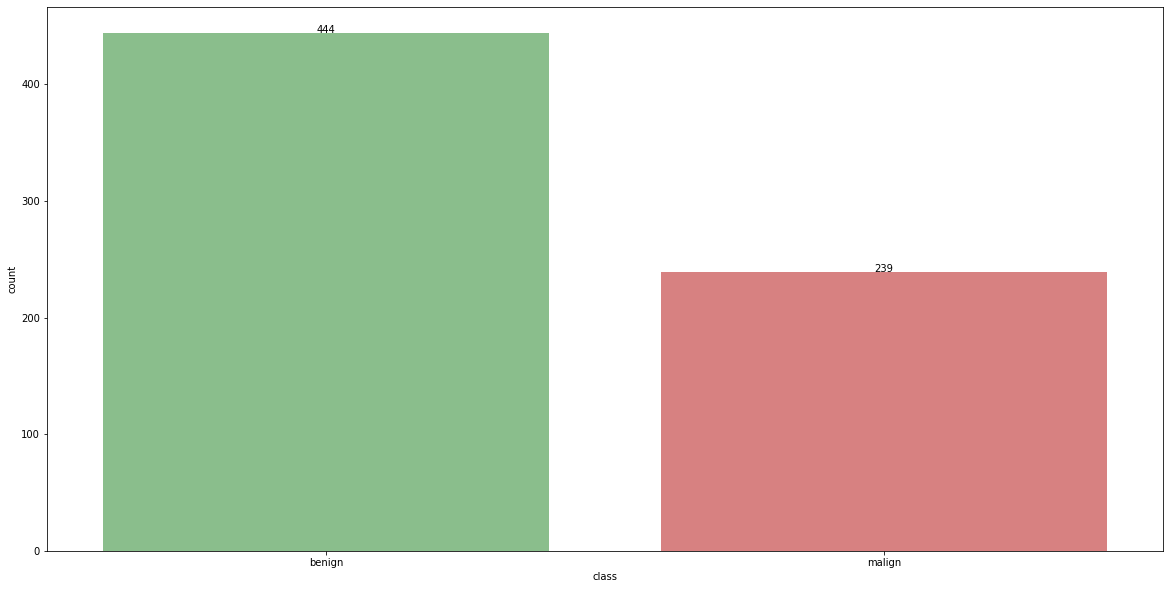

In [12]:
fig, ax1 = plt.subplots(figsize=(20,10), facecolor = "white")
col_dict = {"benign":"#81c784", "malign": "#e57373"}
graph = sns.countplot(dataset_DF["class"], palette=col_dict);
graph.set_xticklabels(graph.get_xticklabels())
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center");

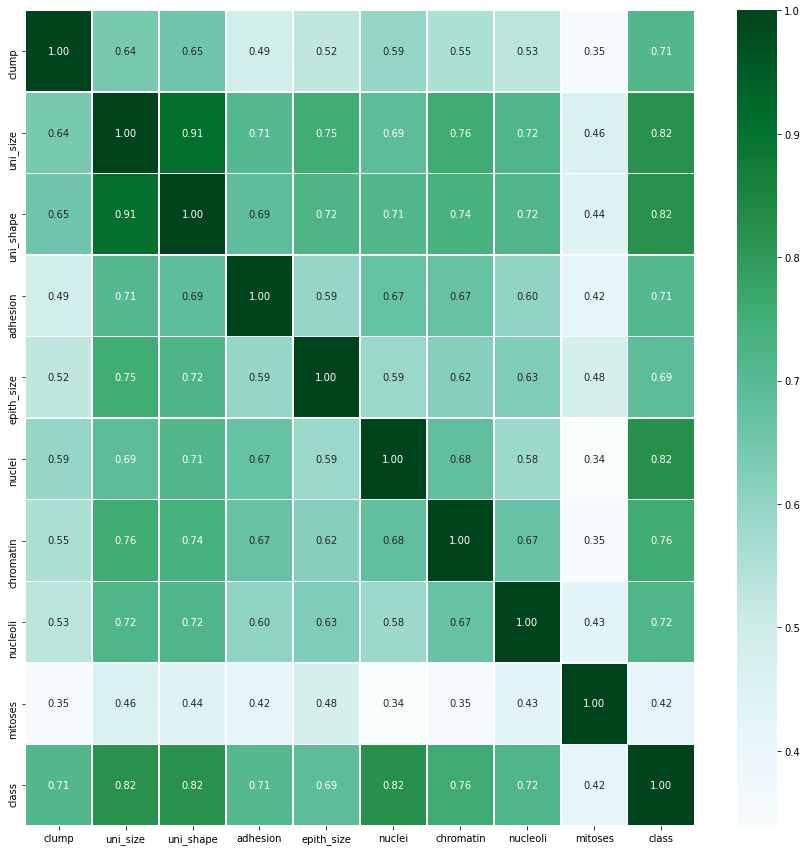

In [13]:
f,ax = plt.subplots(figsize=(15,15), facecolor="white")
sns.heatmap(encoded.corr(), annot=True, linewidths=0.5, fmt='.2f', cmap='BuGn', ax=ax);

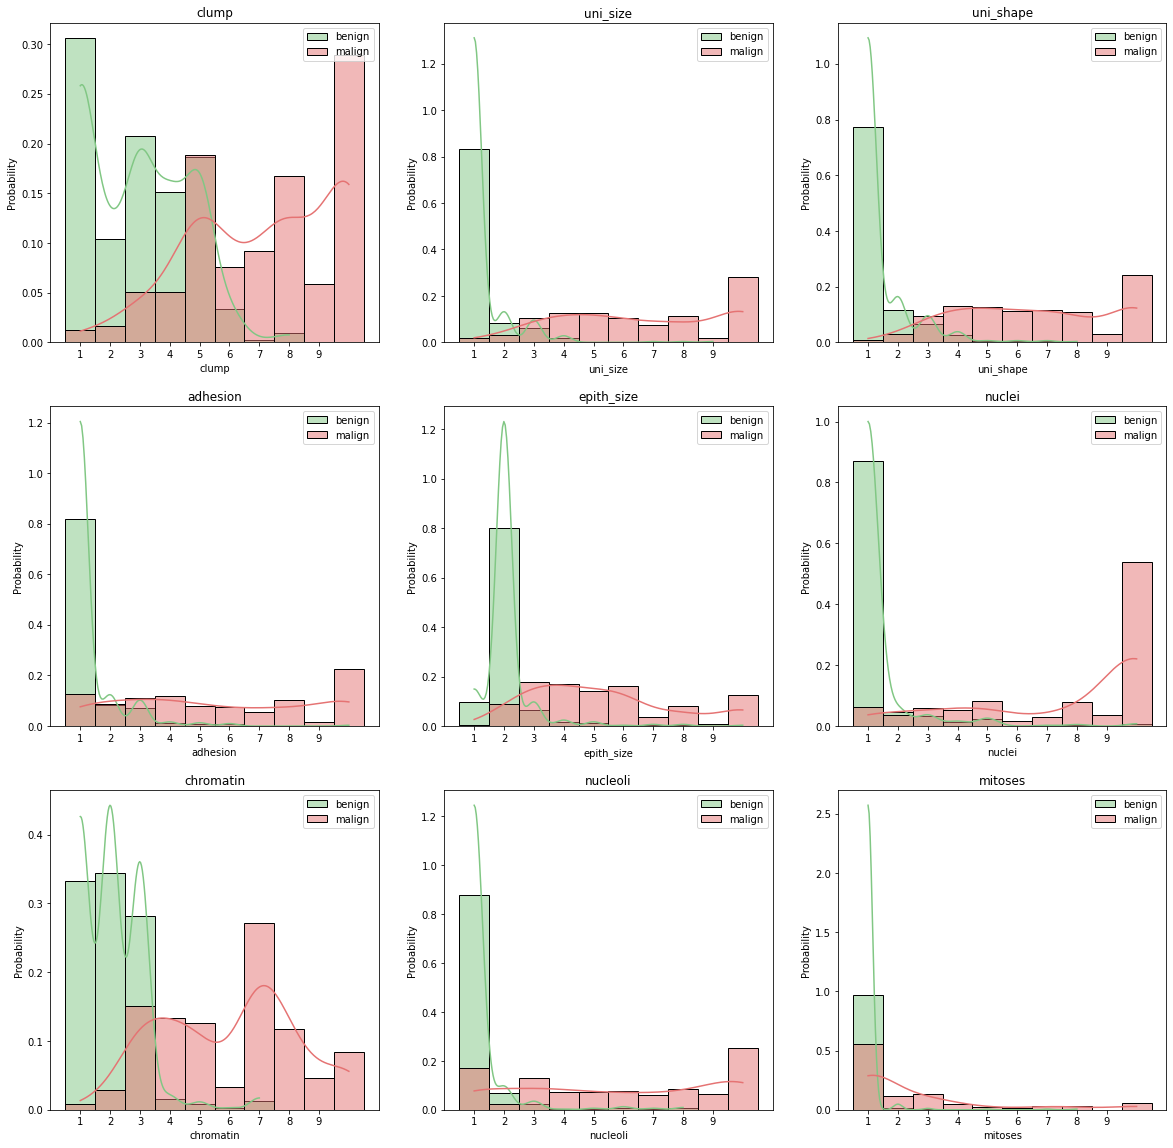

In [14]:
plt.subplots(3, 3, figsize = (20, 20), facecolor = "white")

for i, col in enumerate(dataset_DF.columns[:9]):
  plt.subplot(3, 3, i+1)
  sns.histplot(dataset_DF.loc[dataset_DF['class'] == 'benign', col], stat="probability", label='benign', color="#81c784", element="bars", discrete=True, kde=True)
  sns.histplot(dataset_DF.loc[dataset_DF['class'] == 'malign', col], stat="probability", label='malign', color="#e57373", element="bars", discrete=True, kde=True)
  plt.title(col)
  plt.xticks(np.arange(1,10,1))
  plt.legend(loc='upper right')

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 28.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 68.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 63.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 67.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 65.8% of the points cannot be placed; y

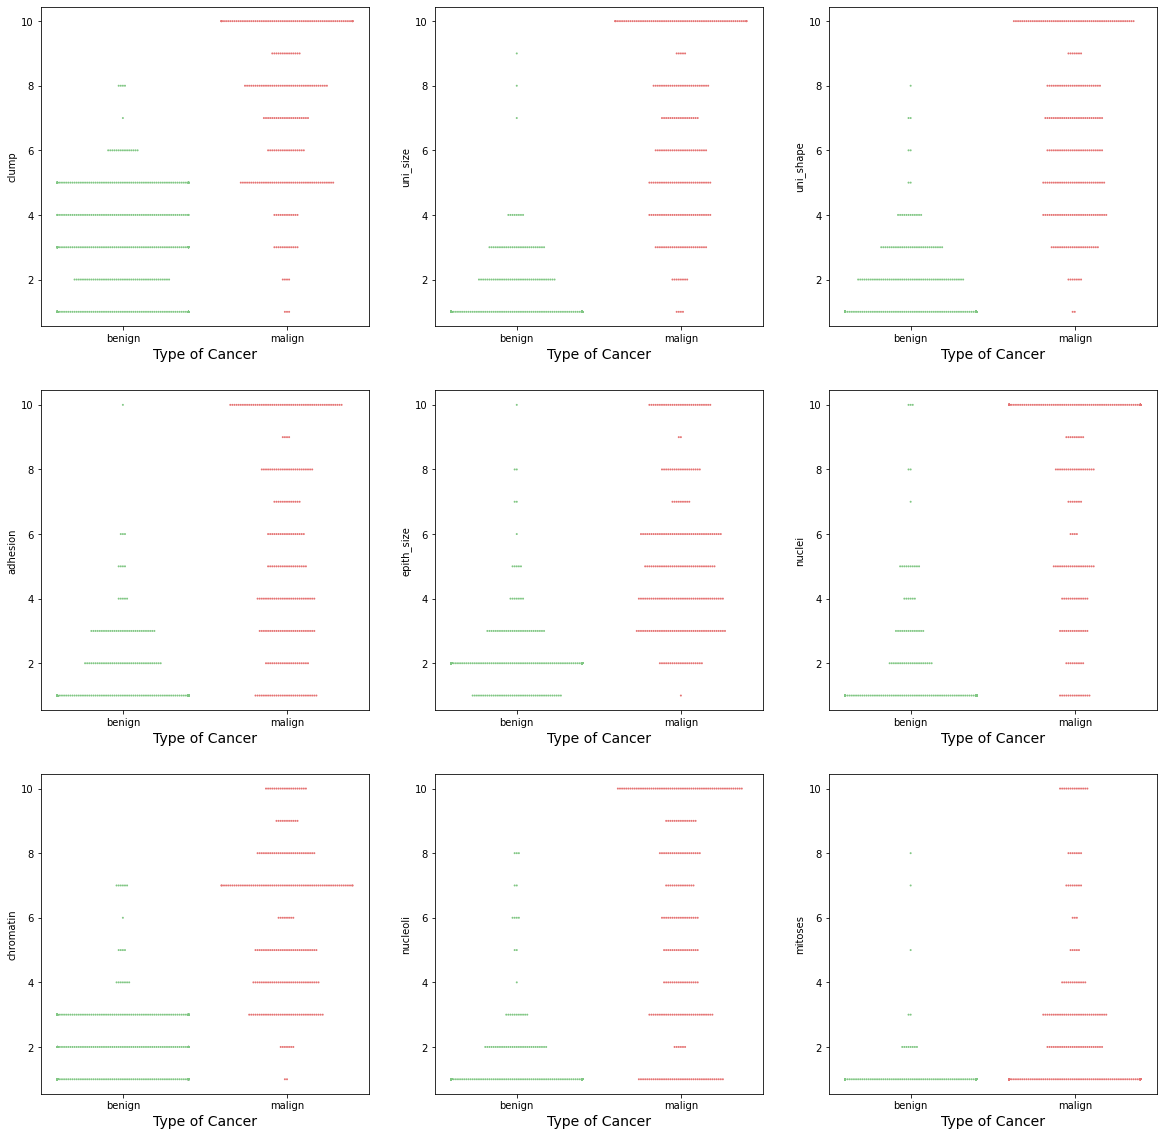

In [15]:
plt.subplots(3, 3, figsize = (20, 20), facecolor = "white")
for i, col in enumerate(dataset_DF.columns[:9]):
  plt.subplot(3, 3, i+1)
  sns.swarmplot(y=dataset_DF.iloc[:, i] , x="class", size=2, palette=col_dict, data=dataset_DF);
  plt.xlabel("Type of Cancer", size=14)

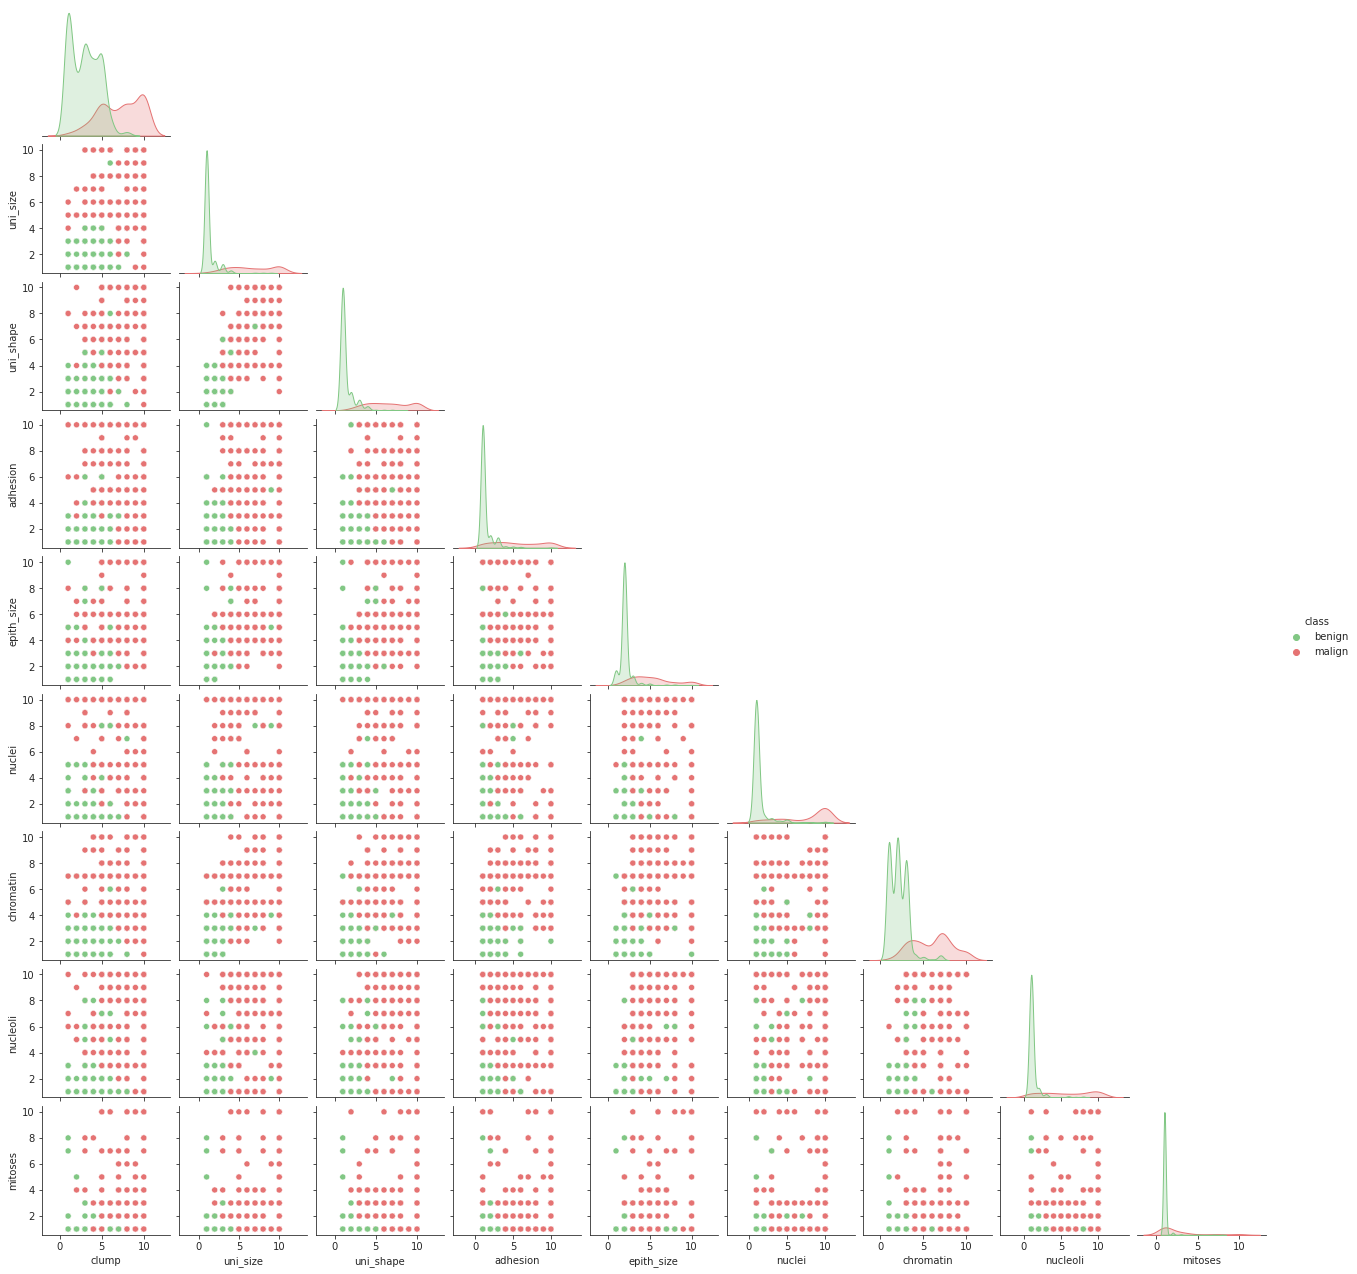

In [16]:
import seaborn as sns
sns.set_style("ticks")
sns.pairplot(dataset_DF, hue = "class", diag_kind="kde", height=2, palette=col_dict, corner=True)


In [34]:
#splitting data and target dataframe
x = encoded.iloc[:, :9]
y = encoded.iloc[:, 9]

seed = 42

In [36]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x = scaler.fit_transform(x)

x = pd.DataFrame(data=x, columns=['clump', 'uni_size', 'uni_shape',	'adhesion',	'epith_size',	'nuclei',	'chromatin', 'nucleoli',	'mitoses'])
x

,clump,uni_size,uni_shape,adhesion,epith_size,nuclei,chromatin,nucleoli,mitoses
0,0.197905,-0.702212,-0.741774,-0.639366,-0.555608,-0.698853,-0.181827,-0.612927,-0.348400
1,0.197905,0.277252,0.262783,0.758032,1.695166,1.772867,-0.181827,-0.285105,-0.348400
2,-0.511643,-0.702212,-0.741774,-0.639366,-0.555608,-0.424217,-0.181827,-0.612927,-0.348400
3,0.552679,1.583204,1.602192,-0.639366,-0.105454,0.125054,-0.181827,1.354008,-0.348400
4,-0.156869,-0.702212,-0.741774,0.059333,-0.555608,-0.698853,-0.181827,-0.612927,-0.348400
...,...,...,...,...,...,...,...,...,...
678,-0.511643,-0.702212,-0.741774,-0.639366,-0.105454,-0.424217,-0.998853,-0.612927,-0.348400
679,-0.866417,-0.702212,-0.741774,-0.639366,-0.555608,-0.698853,-0.998853,-0.612927,-0.348400
680,0.197905,2.236180,2.271896,0.059333,1.695166,-0.149582,1.860738,2.337476,0.229166
681,-0.156869,1.583204,0.932487,0.408682,-0.105454,0.125054,2.677764,1.026185,-0.348400


In [38]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=seed, shuffle=True)

In [39]:
x_train

,clump,uni_size,uni_shape,adhesion,epith_size,nuclei,chromatin,nucleoli,mitoses
437,-0.511643,-0.702212,-0.741774,0.059333,-0.555608,-0.698853,-0.998853,-0.612927,-0.348400
256,0.907453,1.909692,0.262783,2.504778,3.045631,-0.149582,0.635199,0.042718,0.806731
584,0.197905,-0.375724,0.262783,-0.639366,-1.005763,-0.698853,-0.998853,-0.612927,-0.348400
18,1.971775,1.256716,1.267340,1.107381,0.344701,1.772867,0.226686,-0.612927,0.229166
350,-0.866417,-0.702212,-0.741774,-0.639366,-0.555608,-0.698853,-0.181827,-0.612927,-0.348400
...,...,...,...,...,...,...,...,...,...
71,1.617001,0.277252,0.597635,2.504778,1.245011,1.772867,0.226686,1.681830,-0.348400
106,-1.221191,-0.702212,-0.741774,-0.639366,-0.555608,-0.698853,-0.590340,0.042718,-0.348400
270,1.971775,0.603740,1.267340,0.059333,-0.105454,0.948960,-0.181827,0.042718,3.694559
435,-0.156869,-0.702212,-0.741774,0.059333,-1.005763,-0.698853,-0.590340,-0.612927,-0.348400


In [40]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(x_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

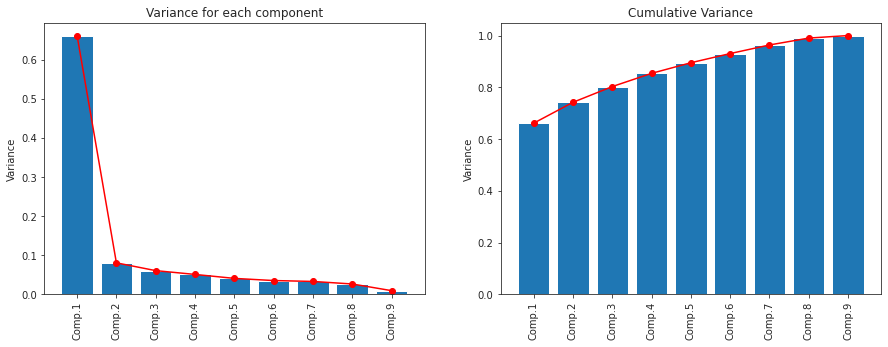